In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# unscaled, log-normalized counts, with conditions subsampled to the same number of cells 
# and 2000 highly variable genes calculated jointly across all perturbation conditions, including control, using scanpy28 with default parameters (Supplementary Methods)

In [3]:
import scanpy as sc
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import os
from anndata import read_h5ad
import seaborn as sns
import sys
sys.path.append("..")
from src import *

will use the CPU to calculate the distance matrix.
will use the CPU to calculate the distance matrix.


/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:33: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:33: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:33: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


In [4]:
data_path = "/mnt/data"

In [5]:
os.listdir(data_path)

['sciplex_K562.hdf5',
 'sciplex_A549.hdf5',
 'sciplex_MCF7.hdf5',
 'schiebinger.hdf5',
 'mcfarland.hdf5',
 'norman.hdf5',
 'kang.hdf5',
 'bhattacherjee.hdf5']

In [6]:
adata = read_h5ad(os.path.join(data_path, 'bhattacherjee.hdf5'))

In [7]:
adata.obs["cell_type"].value_counts()

cell_type
Excitatory    7741
Endo          1708
Oligo          796
Microglia      774
Astro          699
Inhibitory     621
OPC            417
NF Oligo       180
Name: count, dtype: int64

In [8]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

In [9]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
cell_type = "Excitatory"
ct_adata = adata[adata.obs["cell_type"] == cell_type]

/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


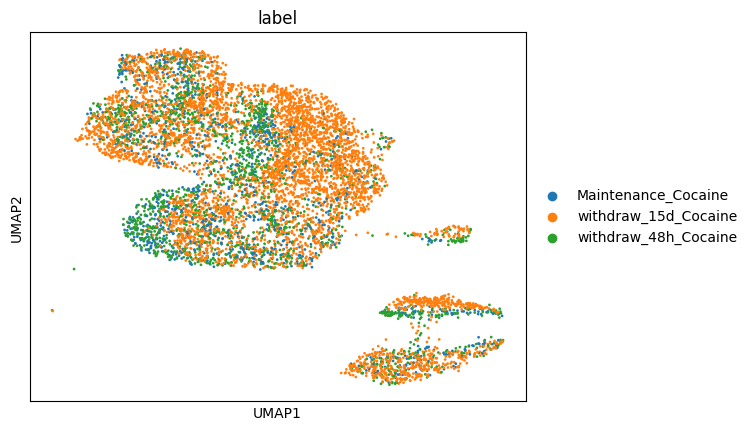

In [11]:
sc.pl.umap(ct_adata, color="label")

In [12]:
withdraw_15d = dict()
withdraw_48h = dict()

In [13]:
for cell_type in np.unique(adata.obs["cell_type"]):
    print(cell_type)
    ct_adata = adata[adata.obs["cell_type"] == cell_type]
    withdraw_15d[cell_type] = rosenbaum(ct_adata, group_by="label", reference="Maintenance_Cocaine", test_group="withdraw_15d_Cocaine", use_nx=False, k=None)
    withdraw_48h[cell_type] = rosenbaum(ct_adata, group_by="label", reference="Maintenance_Cocaine", test_group="withdraw_48h_Cocaine", use_nx=False, k=None)

Astro
XMatch_group
reference    216
test         213
Name: count, dtype: int64
using CPU to calculate distance matrix.


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


creating distance graph with 430 samples
counting cross matches.
XMatch_group
test         270
reference    216
Name: count, dtype: int64
using CPU to calculate distance matrix.


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


creating distance graph with 486 samples
counting cross matches.
Endo
XMatch_group
test         753
reference    478
Name: count, dtype: int64
using CPU to calculate distance matrix.


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


creating distance graph with 1232 samples
counting cross matches.
XMatch_group
reference    478
test         477
Name: count, dtype: int64
using CPU to calculate distance matrix.


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


creating distance graph with 956 samples
counting cross matches.
Excitatory
XMatch_group
test         4789
reference    1264
Name: count, dtype: int64
using CPU to calculate distance matrix.


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


creating distance graph with 6054 samples
counting cross matches.


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


XMatch_group
test         1688
reference    1264
Name: count, dtype: int64
using CPU to calculate distance matrix.
creating distance graph with 2952 samples
counting cross matches.
Inhibitory
XMatch_group
test         357
reference     82
Name: count, dtype: int64
using CPU to calculate distance matrix.


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


creating distance graph with 440 samples
counting cross matches.
XMatch_group
test         182
reference     82
Name: count, dtype: int64
using CPU to calculate distance matrix.
creating distance graph with 264 samples
counting cross matches.
Microglia
XMatch_group
reference    373
test          99
Name: count, dtype: int64
using CPU to calculate distance matrix.


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")
/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


creating distance graph with 472 samples
counting cross matches.
XMatch_group
reference    373
test         302
Name: count, dtype: int64
using CPU to calculate distance matrix.


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


creating distance graph with 676 samples
counting cross matches.
NF Oligo
XMatch_group
test         101
reference     35
Name: count, dtype: int64
using CPU to calculate distance matrix.
creating distance graph with 136 samples


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")
/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")
/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")
/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.o

counting cross matches.
XMatch_group
test         44
reference    35
Name: count, dtype: int64
using CPU to calculate distance matrix.
creating distance graph with 80 samples
counting cross matches.
OPC
XMatch_group
reference    119
test          71
Name: count, dtype: int64
using CPU to calculate distance matrix.
creating distance graph with 190 samples
counting cross matches.
XMatch_group
test         227
reference    119
Name: count, dtype: int64
using CPU to calculate distance matrix.
creating distance graph with 346 samples
counting cross matches.
Oligo
XMatch_group
reference    409
test         240
Name: count, dtype: int64
using CPU to calculate distance matrix.


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


creating distance graph with 650 samples
counting cross matches.
XMatch_group
reference    409
test         147
Name: count, dtype: int64
using CPU to calculate distance matrix.


/mnt/je30bery/rosenbaum_test/notebooks/../src/rosenbaum.py:153: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


creating distance graph with 556 samples
counting cross matches.


In [14]:
withdraw_15d_df = pd.DataFrame(withdraw_15d, index=["p-val", "z-score", "support"])

In [15]:
withdraw_48h_df = pd.DataFrame(withdraw_48h, index=["p-val", "z-score", "support"])

In [16]:
metric = "z-score"

In [37]:
conc = pd.concat([withdraw_15d_df.loc[metric], withdraw_48h_df.loc[metric]], axis=1)
conc.columns = [f"{metric} 15d", f"{metric} 48h"]

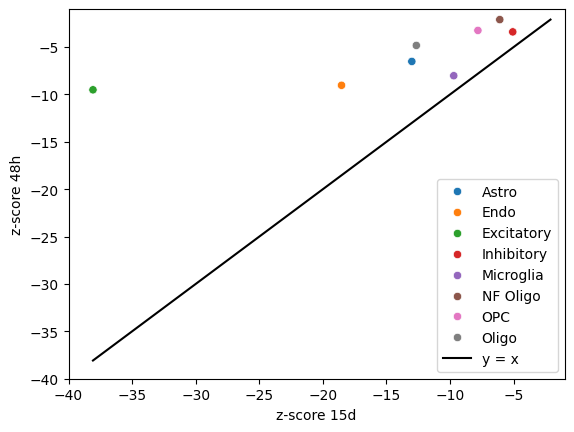

In [40]:
sns.scatterplot(conc.reset_index(), y=f"{metric} 48h", x=f"{metric} 15d", hue="index")
#plt.yscale("log")
#plt.xscale("log")
min_val = np.min(conc[[f"{metric} 48h", f"{metric} 15d"]])
max_val = np.max(conc[[f"{metric} 48h", f"{metric} 15d"]])

x_vals = np.linspace(min_val, max_val, 100)
plt.plot(x_vals, x_vals, linestyle="-", color="black", label="y = x")

plt.ylim(np.floor(min_val) - 1,  np.ceil(max_val) + 1)
plt.xlim(np.floor(min_val) - 1,  np.ceil(max_val) + 1)

plt.legend()
plt.show()